# Transfer matrix method for effective spin-foam cosmology

## Definitions and setup

In [377]:
using Pkg
Pkg.activate("/Users/jercheal/.julia/environments/v1.11/transfer_matrix/")
using Plots
using NLsolve
using BenchmarkTools
using Polylogarithms

using LaTeXStrings
plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=2, framestyle=:box, label=nothing, grid=false)
#scalefontsizes(1.2)

include("wynn.jl")

  Activating project at `~/.julia/environments/v1.11/transfer_matrix`
┌ Warning: Module SpecialFunctions with build ID fafbfcfd-3afc-bc74-0007-484de5580bff is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


wynn (generic function with 1 method)

In [307]:
function height(j0::Float64, j1::Float64, k::Float64)
    res_squared = ((j0 - j1)^2 + 8*k^2)/(2 * (sqrt(j0) + sqrt(j1))^2)
    res = sqrt(complex(res_squared))
    return real(res)
end

function four_volume(j0::Float64, j1::Float64, k::Float64)
    res_squared = (j0 + j1)^2/32 * ((j0 - j1)^2 + 8*k^2)
    res = sqrt(complex(res_squared))
    return real(res)
end

function S_III(j0::Float64, j1::Float64, k::Float64, Λ::Float64) 
    res = 6 * (j0 - j1) * asinh((j1 - j0) / (sqrt(complex(16*k^2 + (j1 - j0)^2)))) + 12 * k * (pi/2 - acos((j0 - j1)^2 / (16*k^2 + (j0 - j1)^2))) - Λ * four_volume(j0, j1, k)
    return real(res)
end

function dS_IIIdk(j0::Float64, j1::Float64, k::Float64, Λ::Float64)
    res = 12 * (pi/2 - acos((j0 - j1)^2 / (16*k^2 + (j0 - j1)^2))) - Λ * ((j0 + j1)^2 * k) / (4 * four_volume(j0, j1, k))
    return res
end

function μ_ESF(j0::Float64, j1::Float64, k::Float64)
    res = 4/sqrt(2) * (height(j0, j1, k) * (sqrt(j0) + sqrt(j1)))^(-3/2) * k
    return real(res)
end

function construct_matrix(jmax::Int64, γ::Float64, Λ::Float64, rtol::Float64)
    N = 2 * jmax
    mat = zeros(ComplexF64, N, N)
    for j0 in 1:N
        for j1 in 1:j0
            kmax = (10 * abs(j0 - j1) + 50)
            kvals = 0.5:0.5:kmax
            amplitudes = [μ_ESF(γ * 0.5 * j0, γ * 0.5 * j1, k) *  exp(im * S_III(γ * 0.5 * j0, γ * 0.5 * j1, k, Λ)) for k in kvals]
            mat_element = wynn(accumulate(+, amplitudes)[2 * kmax - 50:2 * kmax], rtol)[1]
            mat[j0, j1] = mat_element
            mat[j1, j0] = mat_element
        end
    end
    return mat
end

construct_matrix (generic function with 2 methods)

## Finding classical solutions with NLsolve

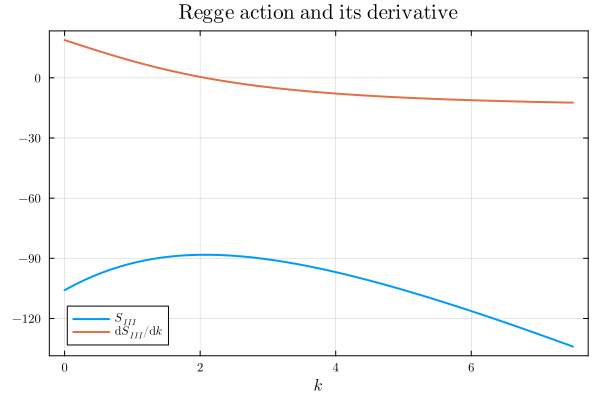

In [3]:
ks = range(0, 7.5, 1000)
S_vals = [S_III(10.0, 20.0, k, 1.0) for k in ks]
dS_vals = [dS_IIIdk(10.0, 20.0, k, 1.0) for k in ks]
plot(ks, S_vals, label=L"S_{III}")
plot!(ks, dS_vals, label=L"\mathrm{d}S_{III}/\mathrm{d}k", xlabel=L"k", title=L"\textrm{Regge~action~and~its~derivative}", grid=true)

For this type of boundary data, we observe that the classical solution should be around k = 2. Let's see if we can reproduce this with the NLsolve package of Julia.

In [4]:
function S_III_fxdbdry(k::Vector{Float64})
    j0 = 10.0
    j1 = 20.0
    Λ = 1.0
    return S_III(j0, j1, k[1], Λ)
end

function dS_III_fxbdry(k::Vector{Float64})
    j0 = 10.0
    j1 = 20.0
    Λ = 1.0
    return dS_IIIdk(j0, j1, k[1], Λ)    
end

sol = nlsolve(S_III_fxdbdry, dS_III_fxbdry, [2.0], iterations=1000, xtol=1e-6, ftol=1e-6)
println("k_sol = ", sol.zero[1])



k_sol = 2.07686179492998


Solving a single Regge equations works straightforwardly with the NLsolve package. It will be important later to see whether this works for multiple variables...

## Establishing the convergence acceleration for partition function and expectation values

Let's choose boundary data $j_0 = 10.0$, $j_1 = 20.0$ and $\Lambda = 1.0$ and look at the partition function and the expectation value of $k$. 

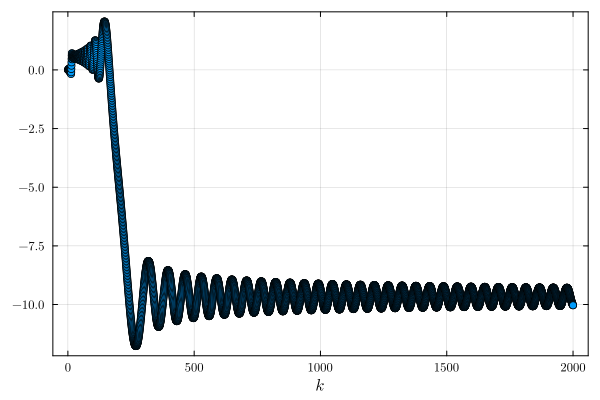

In [365]:
j0 = 3.0
j1 = 47.5
Λ = 1.0
ks = 0.5:0.5:2000.0
integrands = [ μ_ESF(j0, j1, k) * exp(im * S_III(j0, j1, k, Λ)) for k in ks]
integrands_k = [k * μ_ESF(j0, j1, k) * exp(im * S_III(j0, j1, k, Λ)) for k in ks]
part_sums = accumulate(+, integrands)
part_sums_k = accumulate(+, integrands_k)
scatter(ks, real(part_sums), grid=true, xlabel=L"k")
#scatter(ks, real(part_sums_k), grid=true, xlabel=L"k")

In [366]:
transf_mat[6,95]

-9.671603269358888 + 0.7600284863163221im

Wynn's algorithm has been fixed now with a convergence condition. Divergences can be avoided in this way.

In [298]:
wynn(part_sums[500:550], 1e-20)[1]

2.7176627886752933 + 1.2951770132783471im

In [375]:
transf_mat = construct_matrix(50, 1.0, 1.0, 1e-20)

100×100 Matrix{ComplexF64}:
   1.48078-3.47138im   0.0757971-3.19302im   …   -5.70468-8.473im
 0.0757971-3.19302im    0.445897-2.35938im        -5.1998+1.33215im
  -2.43926-2.02329im    -0.56936-2.201im         -1.60195+3.46205im
  -2.56402+1.71668im    -2.33479-0.667857im       2.71766+1.29518im
   1.38103+2.36594im    -1.01872+2.30501im       -2.31433+2.42135im
     1.915-1.20616im     2.24699+0.736326im  …    2.45381-0.657324im
  -1.17274-1.59566im     0.20996-1.99818im       0.851997-1.8165im
  -1.27996+1.54473im    -1.69085+0.215567im       1.77524-0.466495im
   2.03965+0.360163im   0.732014+1.50553im      -0.675765+2.48285im
  -1.00495-1.67461im    0.908882-1.54007im       -1.42105-2.2179im
          ⋮                                  ⋱  
 -0.693682+0.69384im   -0.491661+0.725435im     -0.190312+1.74978im
 -0.107421-0.859417im  -0.292969-0.93016im       0.398314+0.630751im
  0.668929+0.347835im    1.01679+0.264376im      0.558731-0.180732im
 -0.562617+0.335096im  -0.718218+0.8297

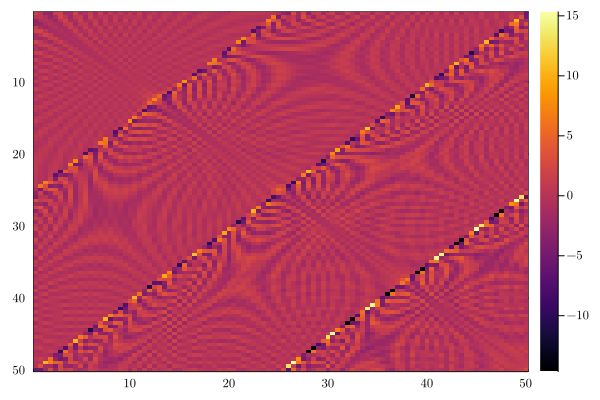

In [ ]:
heatmap(0.5:0.5:50, 0.5:0.5:50, real(transpose(transf_mat)), yflip=true)

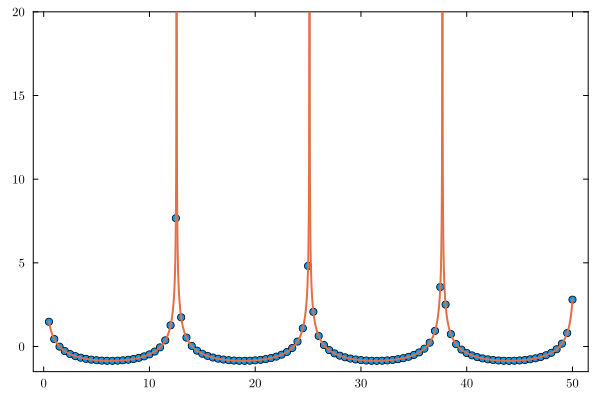

In [394]:
js_fine = 0.5:0.01:50.0
diag_Z = [(1/sqrt(2)) * (polylog(0.5, exp(-im * j / 2)) + polylog(0.5, exp(im * j / 2))) for j in js_fine]
scatter(0.5:0.5:50, real([transf_mat[n, n] for n in 1:100]))
plot!(js_fine, real(diag_Z), ylims=(-1.5,20))

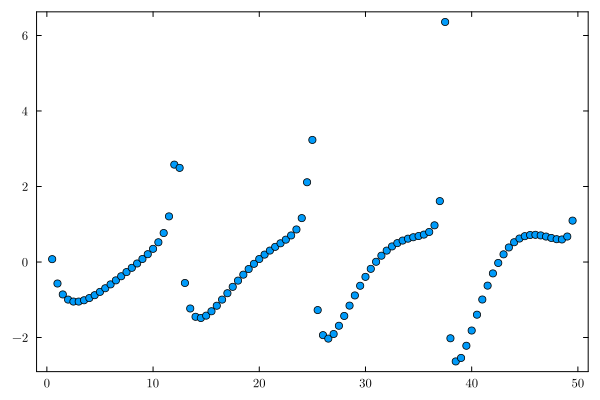

In [400]:
scatter(0.5:0.5:49.5, real([transf_mat[n,n+1] for n in 1:99]))

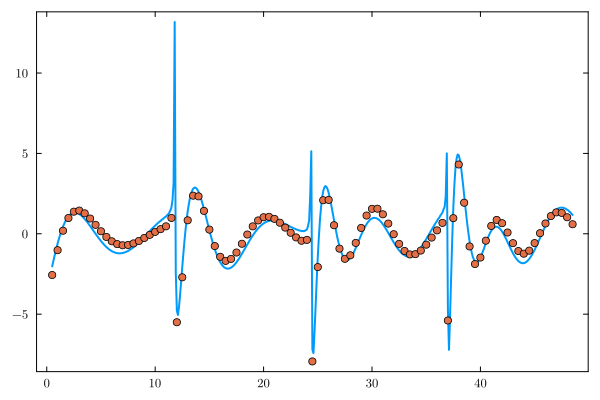

In [ ]:
#function S_III_taylored(j0::Float64, δj::Float64, k::Float64, Λ::Float64)
#   return (δj^2 / k) * (-3/4 - (j0 * Λ)/16) - Λ * (j0 + δj/2) * k
#end

#function coeff1(j0::Float64, δj::Float64, Λ::Float64)
#    return δj^2 * (-3/4 - (j0 * Λ)/16)
#end

function coeff(j0::Float64, j1::Float64, Λ::Float64)
    return - Λ * (j0 + j1)/2 
end

function S_III_lin(j0::Float64, j1::Float64, k::Float64, Λ::Float64)
    return - Λ * ((j0 + j1)/2) * k
end

function Z_approx(j0::Float64, j1::Float64, Λ::Float64, k_large::Float64)
    return sum([μ_ESF(j0, j1, k) * exp(im * S_III(j0, j1, k, Λ)) - (k^(-1/2) - (3/32) * (j0 - j1)^2 * k^(-5/2) + (21/2048) * (j0 - j1)^2 * k^(-9/2)) * exp(im * S_III_lin(j0, j1, k, Λ)) for k in 0.5:0.5:k_large]) + (sqrt(2) * polylog(0.5, exp(im * coeff(j0, j1, Λ)/2)) - (3/sqrt(32)) * (j0 - j1)^2 * polylog(2.5, exp(im * coeff(j0, j1, Λ)/2)) + (21/(64*sqrt(2))) * (j0 - j1)^4 * polylog(4.5, exp(im * coeff(j0, j1, Λ)/2)))
end

#Z1 = [sqrt(2) * (sum([sqrt(n) * exp(im * coeff2(j0, δj, Λ) * n /2) * (exp(im * 2 * coeff1(j0, δj, Λ)/n) - 1) for n in 1:1000]) + polylog(0.5, exp(im * coeff2(j0, δj, Λ)/2))) for j0 in 0.5:0.5:50.0]
#Z2 = [-3/sqrt(32) * δj^2 * (sum([n^(-5/2) * exp(im * coeff2(j0, δj, Λ) * n /2) * (exp(im * 2 * coeff1(j0, δj, Λ)/n) - 1) for n in 1:1000]) + polylog(2.5, exp(im * coeff2(j0, δj, Λ)/2))) for j0 in 0.5:0.5:50.0]
#Z1_alt = [sqrt(2) * (sum([sqrt(n) * exp(im * coeff2(j0, δj, Λ) * n /2) * (exp(im * 2 * coeff1(j0, δj, Λ)/n) - 1) for n in 1:1000]) + polylog(0.5, exp(im * coeff2(j0, δj, Λ)/2))) for j0 in 0.5:0.5:50.0]

#ks = 0.5:0.5:10
#S_III_Tay_vals1 = [S_III_taylored(0.5, 0.5, k, 1.0) for k in ks]
#S_III_Tay_vals2 = [- 1.0 * (0.5 + 0.5/2) * k for k in ks]
#plot(ks, S_III_Tay_vals1)
#plot!(ks, S_III_Tay_vals2)


plot(0.5:0.1:48.5, real([Z_approx(j, j + 1.5, 1.0, 100.0) for j in 0.5:0.1:48.5]))
scatter!(0.5:0.5:48.5, real([transf_mat[n,n+3] for n in 1:97]))

## For comparison: 2 building blocks computed with j1 summation first

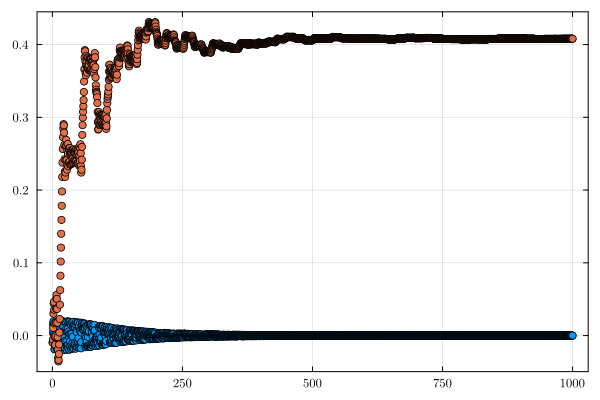

In [519]:
k0 = 50.0
k1 = 50.0
j0 = 10.0
j2 = 20.0
Λ = 1.0
integrand = [μ_ESF(j0, j1, k0) * exp(im * S_III(j0, j1, k0, Λ)) * μ_ESF(j1, j2, k1) * exp(im * S_III(j1, j2, k1, Λ)) for j1 in 0.5:0.5:1000.0]
part_sums = accumulate(+, integrand)
scatter(0.5:0.5:1000.0, real(integrand))
scatter!(0.5:0.5:1000.0, real(part_sums), grid=true)

In [527]:
j1_sum = [wynn(accumulate(+,[μ_ESF(j0, j1, k0) * exp(im * S_III(j0, j1, k0, Λ)) * μ_ESF(j1, j2, k1) * exp(im * S_III(j1, j2, k1, Λ)) for j1 in 0.5:0.5:1000.0]), 1e-20)[1] for k0 in 0.5:0.5:50.0, k1 in 0.5:0.5:50.0]

100×100 Matrix{ComplexF64}:
   0.207396-0.164408im     0.0036468+0.00952627im  …   0.190358+0.45324im
 -0.0107892-0.0148685im     0.312155-0.693334im       -0.220799+0.341613im
   0.584288-0.135939im      -0.24525-0.425828im         -0.3426-0.368159im
   0.107745-0.319173im   -0.00838455-0.00264241im      0.305088-0.341731im
  -0.258716+0.538334im      0.389401-0.160295im        0.488328+0.150779im
    1.57523-0.134701im     -0.909858+0.198556im    …  0.0348768+0.643567im
   -1.54924-0.307587im       1.38067-0.963135im       -0.139802+0.0400947im
   0.967493-0.69687im      -0.551107+1.04518im         0.061515-0.577142im
   0.568518+1.13579im      -0.296743-0.0253973im       0.238252+0.504384im
   -1.22082+0.542894im     -0.347038-0.261755im       -0.396189-0.278295im
           ⋮                                       ⋱  
   0.382287-0.363077im     0.0565861+0.327614im       0.0690293+0.11653im
  -0.225498-0.233786im     0.0533744+0.179782im       0.0639518+0.0416465im
  -0.142787+0.030

In [546]:
j1_sum_alt = [sum([μ_ESF(j0, j1, k0) * exp(im * S_III(j0, j1, k0, Λ)) * μ_ESF(j1, j2, k1) * exp(im * S_III(j1, j2, k1, Λ)) for j1 in 0.5:0.5:1100.0]) for k0 in 0.5:0.5:100.0, k1 in 0.5:0.5:100.0]

200×200 Matrix{ComplexF64}:
   0.207396-0.164408im    -0.217852-0.60787im    …    0.301944+0.163095im
   -0.76999-0.792805im     0.312154-0.693335im       0.0183986+0.295022im
   0.584287-0.135939im    -0.245247-0.425829im       -0.378664-0.0237411im
   0.107745-0.319175im     -1.12174-0.773381im       0.0325655-0.255343im
  -0.258714+0.538334im     0.389396-0.160295im        0.357067+0.0414745im
    1.57523-0.1347im      -0.909863+0.198555im   …    0.209465+0.405052im
   -1.54924-0.307584im      1.38066-0.963139im       -0.180117+0.178193im
   0.967494-0.696867im    -0.551112+1.04517im        0.0115819-0.529422im
    0.56852+1.13579im     -0.296753-0.0254005im       0.166742+0.388867im
   -1.22081+0.542896im    -0.347046-0.261753im       -0.209395+0.000766859im
           ⋮                                     ⋱  
   0.106767-0.206805im   -0.0793709+0.141406im      0.00547708+0.0784421im
 -0.0975594-0.347096im     0.263955+0.224261im      -0.0937829+0.0348103im
  -0.385828+0.085104im  

</test>

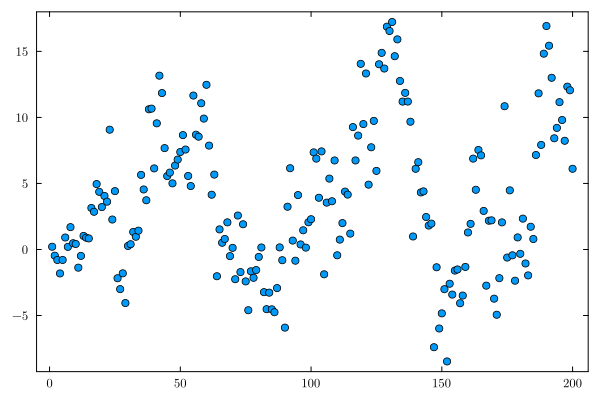

In [547]:
#scatter(real([j1_sum_alt[n,n+1] for n in 1:99]))
scatter(real(acc_rect(j1_sum_alt, 200)))